## LM3331 INDIVIDUAL PROJECT III: Optimization

**TU Delft**<br>
**Q1 2021**<br>
**Modelling and Computation for Life Science and Technology**<br>

**Done by:** Raquel Romão, student number 5629608


---

#### Data management

In [1]:
#To import the necessary libraries
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar

In [2]:
#To import the data from the excel file in 'data' folder
d = 'data/Data_N2O.xlsx'

exp_data = pd.read_excel(d)
exp_data

,t(min),N2O(mM)
0,0,0.355610
1,1,0.339490
2,2,0.323284
3,3,0.307863
4,4,0.293307
5,5,0.279211
6,6,0.265676
7,7,0.252332
8,8,0.239519
9,9,0.226673


In [3]:
#Converts the set of values for the experimental time to a numpy array
time = exp_data['t(min)'].to_numpy()
time

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

In [4]:
#Converts the set of values for the experimental N2O concentration to a numpy array
C_N2O = exp_data['N2O(mM)'].to_numpy()
C_N2O

array([0.35561013, 0.33948976, 0.32328354, 0.30786321, 0.2933068 ,
       0.27921084, 0.265676  , 0.25233159, 0.23951942, 0.22667291,
       0.21431182, 0.20207483, 0.19009693, 0.17788334, 0.16604826,
       0.15430995, 0.14267872, 0.13122651, 0.11983315, 0.10831086,
       0.09708591, 0.08567366, 0.07420444, 0.06281217, 0.05161812,
       0.04050478, 0.02916589, 0.01806471, 0.00736249, 0.00147351])

#### Initial values to use

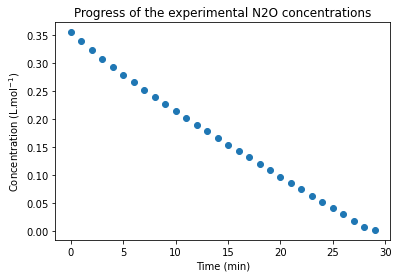

In [6]:
plt.scatter(time, C_N2O)

plt.title('Progress of the experimental N2O concentrations')

plt.xlabel('Time (min)')

plt.ylabel('Concentration (L.mol$^{-1}$)')

plt.show()

In order to predict which initial value should I use to determine r, I ploted the experimental data and determined the slope between the two first points, for which saturation is assumed and rT=0, since dC/dt = r + rT.

In [7]:
slope, intercept = np.polyfit([time[0], time[1]], [C_N2O[0], C_N2O[1]], 1) #for the first two points
print("Inicial value for r:", slope) #to use as the inicial value for r (assuming that rT=0)

Inicial value for r: -0.01612037210463843


Similarly, assuming that in the beginning of the simulation the system is saturated (and therefore, rT = 0), we can calculate the initial value for the concentration of N2O in the gas phase from the experimental data. For the initial concentration of N2O in the liquid phase I chose to use the experimental data for t = 0.

In [8]:
KH = 27.05 #mM/atm
p = 1 #atm
R = 8.206e-5 #L.atm/(K.mmol)
T = 293.15 #K
kLa = 5/60 #1/min (the time in the dataset is in minutes)
VL = 2 #L
VG = 1 #L

t_span = [time[0], time[-1]] #the same time as the experimental data

y0 = [C_N2O[0], (C_N2O[0]/KH)*(p/(R*T))] #inicial values from the experimental data (assuming saturation)

In [9]:
y0, t_span

([0.35561013298370475, 0.5464940613913327], [0, 29])

#### Definition of ODE system and cost function

To determine the maximum N2O consumption rate, I had to define a cost function (**`SSE`**) and then minimize it. 
<br>
**`SSE`** receives as an input `r` and, after calculating the simulated concentrations of N2O through time, it determines the sum of squared errors between those values and the experimental data. In this way, we will minimize the "gap" between these different sets of values, making it possible to obtain a maximum N2O consumption rate close to reality. That is why I will use minimizing optimizers.
<br>
In order to calculate the simulated concentrations I used `solve_ivp` to solve the ODE that translates the simulation (based on mass balances and gas-liquid transfer equations), defined below as `N2O_sim`. 
<br>
It's to note that, to make this possible, I had to include an extra argument in `solve_ivp` function, args = [r], since my simulation function has `r` as an extra argument, besides the time and the array with the concentration of NO2 in both phases.

In [10]:
def N2O_sim(t, y, r):
    '''ODE that defines the variation of N2O concentrations in each phase through time'''

    C, Cg = y[0], y[1]
    
    CS = KH * (R*T/p) * Cg
    rT = kLa * (CS - C)
    dC = r + rT
    dCg = - (VL/VG) * rT
    
    return [dC, dCg]

I tested different tolerances to use in `solve_ivp` but I ended up choosing to use the default values:

In [11]:
def SSE(r):
    '''Function whose output is the sum of squared errors between the simulated N2O concentrations and the experimental data.'''
    
    errors = 0
    
    #To get the concentrations of N2O through time, solving N2O_sim
    sim = solve_ivp(N2O_sim, t_span, y0, method='Radau', t_eval=time, args=[r])
    
    sim_N2O = sim.y[0]
    
    i = 0
    for N2O in C_N2O:
        
        errors += (N2O - sim_N2O[i])**2
        
        i+=1
    
    return errors

#### Determination of the maximum N2O consumption rate

Then, I minimized the `SSE` function to find the maximum `r` value (represented as x in the results obtained), using the `minimize` and `minimize_scalar` python built-in functions (while testing different methods):

In [12]:
r0 = -0.01612037210463843; TolX = 1e-6
minimize(SSE, r0, method='Nelder-Mead', tol=TolX)

 final_simplex: (array([[-0.01907525],
       [-0.01907446]]), array([0.00021922, 0.00021922]))
           fun: 0.0002192203133886138
       message: 'Optimization terminated successfully.'
          nfev: 26
           nit: 13
        status: 0
       success: True
             x: array([-0.01907525])

In [13]:
minimize(SSE, r0, method='SLSQP', tol=TolX)

     fun: 0.0002192203126243988
     jac: array([1.76771791e-05])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([-0.01907524])

In [14]:
res = minimize_scalar(SSE, method='brent', tol=TolX)
print('x:', res.x, ', fun:', res.fun, ', nit:', res.nit,', nfev:', res.nfev)

x: -0.01907524248007658 , fun: 0.0002192203128019578 , nit: 5 , nfev: 9


With all of them I obtained the same value up to at least the 7th decimal place : `-0.0190752`. Therefore, I can assume this is the value for the maximum N2O consumption rate that I wanted to obtain.

<br>

Taking the results obtained into account, in a further approach, I would chose to use the 'SLSQP' method, since it was the one with the least number of iterations as well as function evaluations.

Then, I plotted both the simulated data and the experimental data, using the `r` obtained:

In [15]:
to_plot = solve_ivp(N2O_sim, t_span, y0, method='Radau', t_eval=time, args=[-0.0190752])

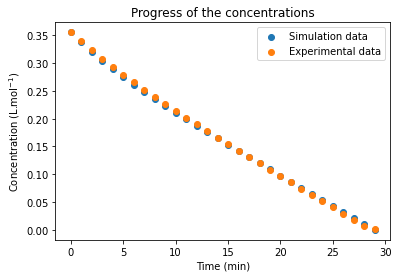

In [16]:
plt.scatter(to_plot.t, to_plot.y[0], label = "Simulation data")
plt.scatter(time, C_N2O, label = "Experimental data")
    
plt.xlabel('Time (min)')

plt.ylabel('Concentration (L.mol$^{-1}$)')
 
plt.title('Progress of the concentrations')
    
plt.legend()


Indeed, the difference between the two was minimized as their points almost overlap completely.